In [1]:
import pandas as pd
import re
from pulp import *
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pwd = Path().cwd()
data_dir = pwd / "data"

In [3]:
# df = pd.read_csv(data_dir / "players_raw.csv")
df = pd.read_csv(data_dir / "gw1.csv")
df_teams = pd.read_csv(data_dir / "teams.csv")

In [4]:
df.head()

,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,code,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,cost_change_event,...,threat_rank_type,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,yellow_cards
0,0,0,0,None,None,0,58822,2,NaN,0,...,111,0,671,671,3556,3556,0.0,0.0,Cédric,0
1,0,0,12,None,None,1,84450,None,NaN,0,...,90,2,4140,4140,4558,4558,0.4,0.4,Xhaka,1
2,0,0,0,None,None,0,153256,None,NaN,0,...,115,0,2943,2943,10103,10103,0.0,0.0,Elneny,0
3,0,0,0,None,None,0,156074,None,NaN,0,...,137,0,283,283,1968,1968,0.0,0.0,Holding,0
4,0,0,17,None,None,1,167199,None,NaN,0,...,57,3,5902,5902,3984,3984,0.6,0.6,Partey,0


In [5]:
teams_dict = pd.Series(df_teams.short_name.values,index=df_teams.id).to_dict()
pos_dict = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}

In [6]:
df_modify = df.copy()

In [7]:
df_modify["name"] = df["first_name"] + " " + df["second_name"]

In [8]:
df_modify.drop(columns=["first_name", "second_name"], axis=1, inplace=True)

In [9]:
df_modify.columns

Index(['assists', 'bonus', 'bps', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'clean_sheets', 'code',
       'corners_and_indirect_freekicks_order',
       'corners_and_indirect_freekicks_text', 'cost_change_event',
       'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall',
       'creativity', 'creativity_rank', 'creativity_rank_type',
       'direct_freekicks_order', 'direct_freekicks_text', 'dreamteam_count',
       'element_type', 'ep_next', 'ep_this', 'event_points', 'form',
       'goals_conceded', 'goals_scored', 'ict_index', 'ict_index_rank',
       'ict_index_rank_type', 'id', 'in_dreamteam', 'influence',
       'influence_rank', 'influence_rank_type', 'minutes', 'news',
       'news_added', 'now_cost', 'own_goals', 'penalties_missed',
       'penalties_order', 'penalties_saved', 'penalties_text', 'photo',
       'points_per_game', 'red_cards', 'saves', 'selected_by_percent',
       'special', 'squad_number', 'status', 'team', 't

In [10]:
df_modify.rename({"element_type": "position", "now_cost": "value"}, inplace=True, axis=1)

In [11]:
features = df_modify[['name', "team", 'position', 'total_points', 'value']]

In [12]:
features

,name,team,position,total_points,value
0,Cédric Alves Soares,1,2,0,45
1,Granit Xhaka,1,3,2,50
2,Mohamed Elneny,1,3,0,45
3,Rob Holding,1,2,0,45
4,Thomas Partey,1,3,3,50
...,...,...,...,...,...
568,Jackson Smith,20,1,0,40
569,Hugo Bueno López,20,2,0,40
570,Joseph Hodge,20,3,0,45
571,Connor Ronan,20,3,0,45


In [13]:
features["team"] = features["team"].map(teams_dict)
features["position"] = features["position"].map(pos_dict)

C:\Users\user\AppData\Local\Temp\ipykernel_4020\1191323582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["team"] = features["team"].map(teams_dict)
C:\Users\user\AppData\Local\Temp\ipykernel_4020\1191323582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["position"] = features["position"].map(pos_dict)


In [14]:
features

,name,team,position,total_points,value
0,Cédric Alves Soares,ARS,DEF,0,45
1,Granit Xhaka,ARS,MID,2,50
2,Mohamed Elneny,ARS,MID,0,45
3,Rob Holding,ARS,DEF,0,45
4,Thomas Partey,ARS,MID,3,50
...,...,...,...,...,...
568,Jackson Smith,WOL,GK,0,40
569,Hugo Bueno López,WOL,DEF,0,40
570,Joseph Hodge,WOL,MID,0,45
571,Connor Ronan,WOL,MID,0,45


In [40]:
POS = features.position.unique()
CLUBS = features.team.unique()
BUDGET = 1000
pos_available = {
    'DEF': 5,
    'FWD': 3,
    'MID': 5,
    'GK': 2,
}

# Initialize Variables
names = [features.name[i] for i in features.index]
teams = [features.team[i] for i in features.index]
positions = [features.position[i] for i in features.index]
prices = [features.value[i] for i in features.index]
points = [features.total_points[i] for i in features.index]
players = [LpVariable("player_" + str(i), cat="Binary") for i in features.index]

In [41]:
# Initialize the problem
prob = LpProblem("FPL_Player_Choices", LpMaximize)

In [42]:
# Define the objective
prob += lpSum(players[i] * points[i] for i in range(len(features))) # Objective

In [43]:
# Build the constraints
prob += lpSum(players[i] * features.value[features.index[i]] for i in range(len(features))) <= BUDGET # Budget Limit

for pos in POS:
  prob += lpSum(players[i] for i in range(len(features)) if positions[i] == pos) <= pos_available[pos] # Position Limit

for club in CLUBS:
  prob += lpSum(players[i] for i in range(len(features)) if teams[i] == club) <= 3 # Club Limit

In [44]:
# Solve the problem
prob.solve()

1

In [45]:
player_names = []
player_clubs = []
player_positions = []
player_prices = []
player_points = []

In [46]:
for v in prob.variables():
  if v.varValue != 0:
    name = features.name[int(v.name.split("_")[1])]
    club = features.team[int(v.name.split("_")[1])]
    position = features.position[int(v.name.split("_")[1])]
    point = features.total_points[int(v.name.split("_")[1])]
    price = features.value[int(v.name.split("_")[1])]

    player_names.append(name)
    player_clubs.append(club)
    player_positions.append(position)
    player_prices.append(price)
    player_points.append(point)
    
    print(name, position, club, point, price, sep=" | ")

Pascal Groß | MID | BHA | 15 | 55
Jorge Luiz Frello Filho | MID | CHE | 11 | 60
Ben Chilwell | DEF | CHE | 9 | 60
Edouard Mendy | GK | CHE | 7 | 50
Aleksandar Mitrović | FWD | FUL | 13 | 66
Oleksandr Zinchenko | DEF | ARS | 12 | 51
Kiernan Dewsbury-Hall | MID | LEI | 10 | 50
Mohamed Salah | MID | LIV | 12 | 130
Ederson Santana de Moraes | GK | MCI | 7 | 55
Erling Haaland | FWD | MCI | 13 | 116
Fabian Schär | DEF | NEW | 15 | 45
Emerson Leite de Souza Junior | DEF | TOT | 9 | 50
Dejan Kulusevski | MID | TOT | 13 | 80
Lloyd Kelly | DEF | BOU | 12 | 45
Ivan Toney | FWD | BRE | 8 | 70


In [47]:
squad = pd.DataFrame({"name": player_names, "position": player_positions, "club": player_clubs, "price": player_prices, "point": player_points})

In [48]:
squad.sort_values(by="position")

,name,position,club,price,point
2,Ben Chilwell,DEF,CHE,60,9
5,Oleksandr Zinchenko,DEF,ARS,51,12
10,Fabian Schär,DEF,NEW,45,15
11,Emerson Leite de Souza Junior,DEF,TOT,50,9
13,Lloyd Kelly,DEF,BOU,45,12
4,Aleksandar Mitrović,FWD,FUL,66,13
9,Erling Haaland,FWD,MCI,116,13
14,Ivan Toney,FWD,BRE,70,8
3,Edouard Mendy,GK,CHE,50,7
8,Ederson Santana de Moraes,GK,MCI,55,7


In [49]:
squad["point"].sum()

166

In [50]:
score = str(prob.objective)
constraint = [str(const) for const in prob.constraints.values()][0]
for v in prob.variables():
  score = score.replace(v.name, str(v.varValue))
  constraint = constraint.replace(v.name, str(v.varValue))

score_pretty = " + ".join( re.findall('[0-9\.]*\*1.0', score) )
constraint_pretty = " + ".join( re.findall('[0-9\.]*\*1.0', constraint) )


# print("Constraint: ")
# print(constraint_pretty + " = " + str(eval(constraint_pretty)))
# print()
# print("Score: ")
# print(score_pretty + " = " + str(eval(score_pretty)))

# GW1 Analysis

In [15]:
plt.style.use('seaborn')

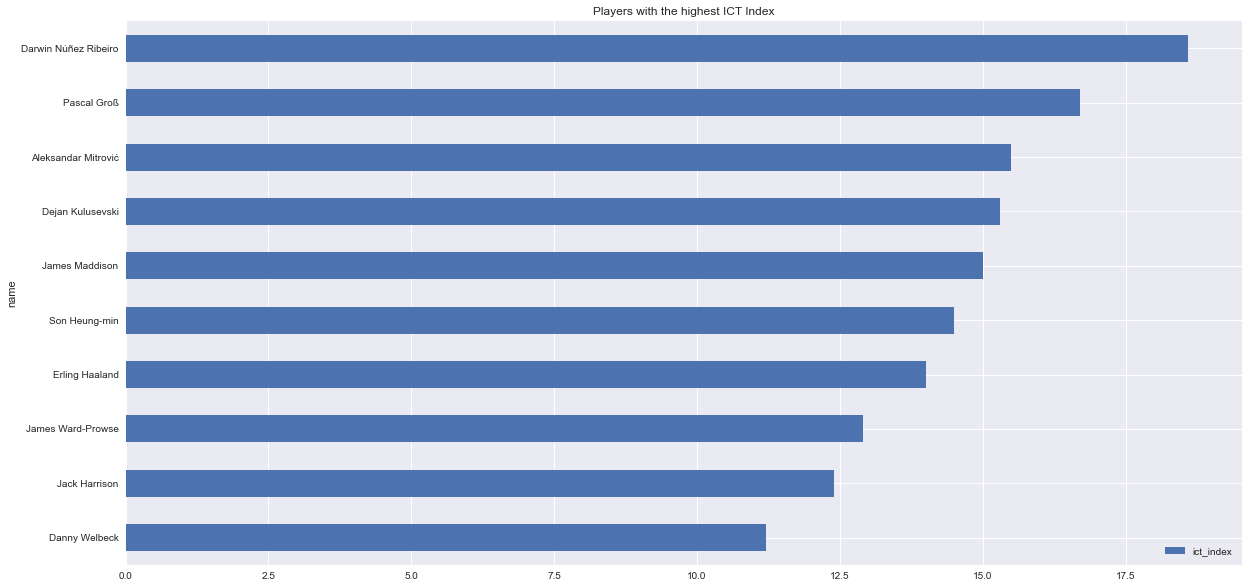

In [30]:
df_modify.sort_values(by="ict_index", ascending=False).nlargest(n=10, columns="ict_index").plot(kind="barh", x="name", y="ict_index", figsize=(20, 10), title="Players with the highest ICT Index").invert_yaxis()

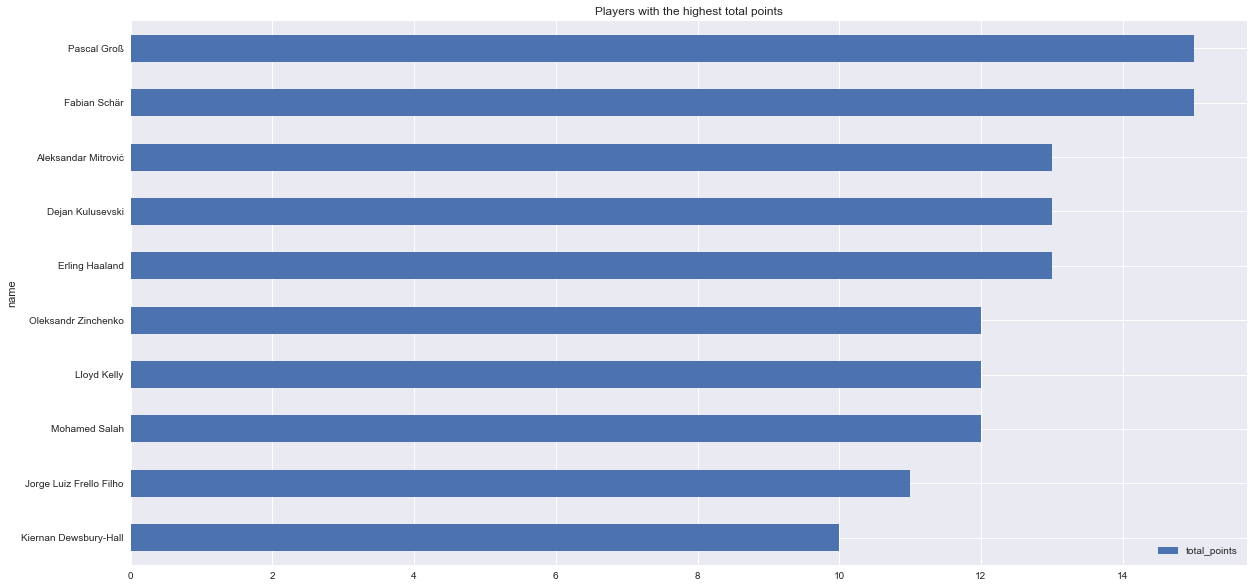

In [29]:
df_modify.sort_values(by="total_points", ascending=False).nlargest(n=10, columns="total_points").plot(kind="barh", x="name", y="total_points", figsize=(20, 10), title="Players with the highest total points").invert_yaxis()

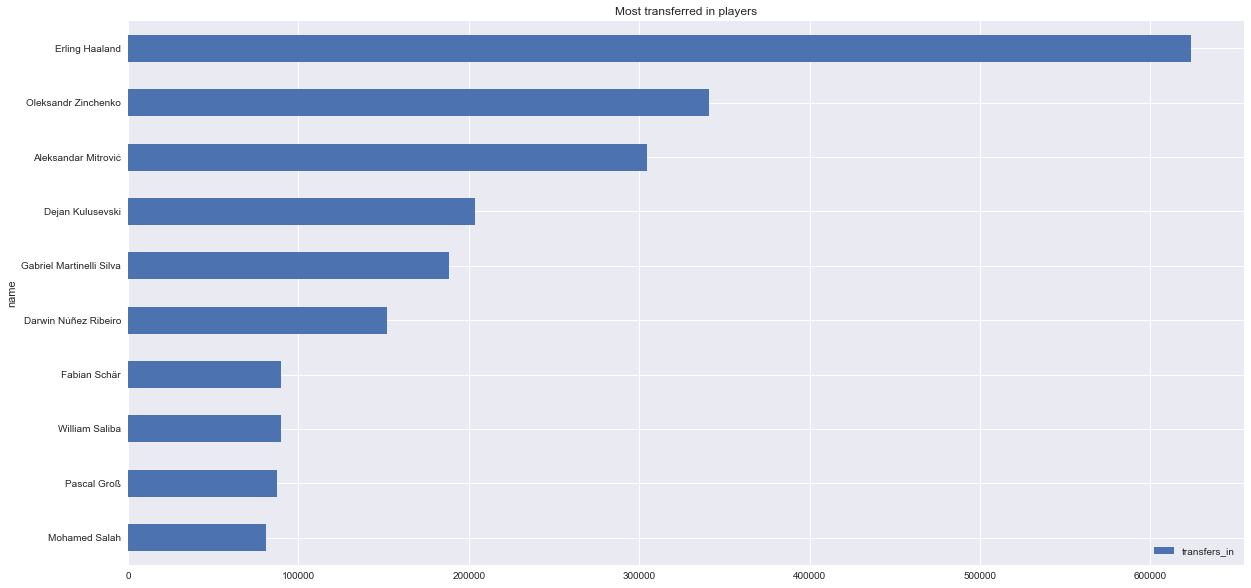

In [32]:
df_modify.sort_values(by="transfers_in", ascending=False).nlargest(n=10, columns="transfers_in").plot(kind="barh", x="name", y="transfers_in", figsize=(20, 10), title="Most transferred in players").invert_yaxis()

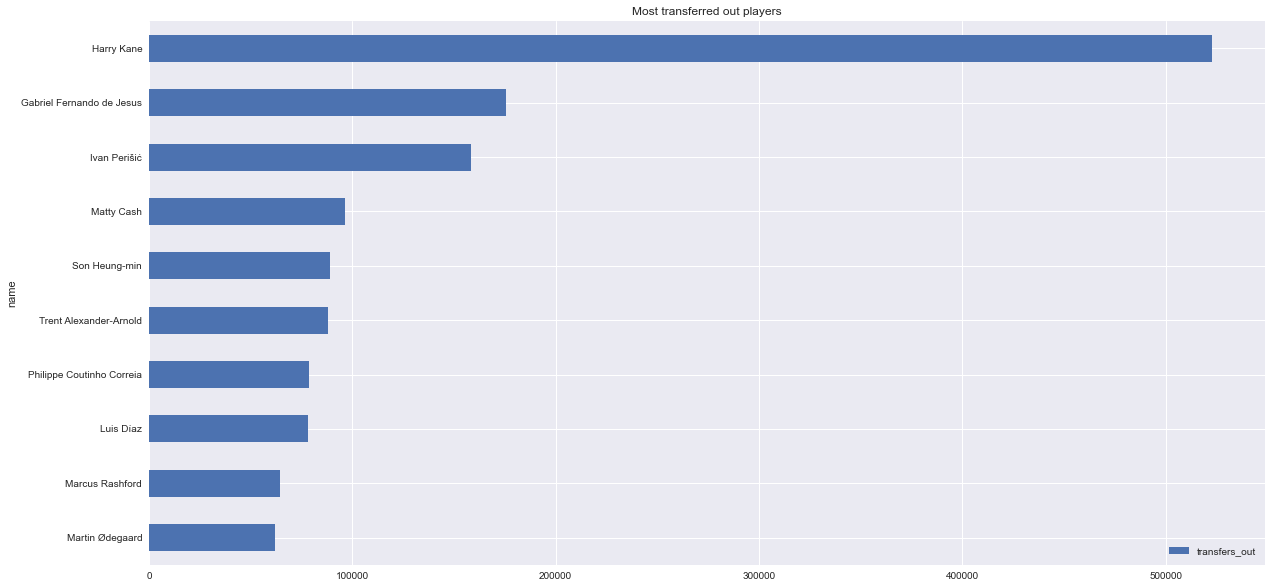

In [33]:
df_modify.sort_values(by="transfers_out", ascending=False).nlargest(n=10, columns="transfers_out").plot(kind="barh", x="name", y="transfers_out", figsize=(20, 10), title="Most transferred out players").invert_yaxis()